#Imports

In [1]:
!pip install hf_xet
!pip install kneed

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
from joblib import Parallel, delayed
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from io import StringIO
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import shuffle
from tqdm import tqdm
import os
from sklearn.impute import KNNImputer
from kneed import KneeLocator
from scipy.stats import randint
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import pickle
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

2025-04-28 16:01:00.267924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745856060.290567     226 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745856060.297540     226 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df = pd.read_csv('/kaggle/input/guests/GuestSatisfactionPrediction.csv', low_memory=False)
df.shape

(8724, 69)

In [5]:
df.head()

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,number_of_stays,first_review,last_review,review_scores_rating,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,21514496,https://www.airbnb.com/rooms/21514496,PRIVATE BEDROOM DOWNTOWN 2 BED/ 2 BATH #5,Beautiful 2 bedroom 2 bathroom furnished apart...,Each apartment is fully furnished and consists...,Beautiful 2 bedroom 2 bathroom furnished apart...,NaN,***Note that the pictures on the website may o...,NaN,NaN,...,2,11/17/2017,11/17/2017,80.0,f,f,f,strict_14_with_grace_period,f,f
1,990185,https://www.airbnb.com/rooms/990185,4 bed/2 ba Family Retreat in SD,We feel our house is a great place for a famil...,Our house is ideal for large families or group...,We feel our house is a great place for a famil...,Neighborhood Mira Mesa is a culturally diverse...,NaN,NaN,Our guests may use the BBQ grill.,...,26,8/2/2013,7/31/2019,97.0,f,f,f,moderate,f,f
2,19878244,https://www.airbnb.com/rooms/19878244,San Diego Dream Villa,"Zen, Luxury and the Best Location in Americas ...","San Diego Dream Villa, this unique and luxurio...","Zen, Luxury and the Best Location in Americas ...",This amazing house is located within a few min...,Im always available to make your trip experien...,"If you are bringing your car, remember that SD...",A couple of days before your arrival you will ...,...,170,7/23/2017,7/16/2019,98.0,f,f,f,strict_14_with_grace_period,f,f
3,24561458,https://www.airbnb.com/rooms/24561458,Studio with Piazza View in Downtown Little Italy,Start the day with breakfast on the sunny pati...,"Newly built, this beautiful studio is located ...",Start the day with breakfast on the sunny pati...,"Spend the day at the zoo in Balboa Park, or ex...",The apartment is located on the Piazza Della F...,"MTS, Train, and Trolly are close by. The airpo...",You will not be sharing the apartment with any...,...,212,5/1/2018,8/3/2019,98.0,f,t,f,moderate,f,f
4,32269829,https://www.airbnb.com/rooms/32269829,Beachside Retreat w/ Private Rooftop Deck w/ V...,This is a 2 bedroom/1 bathroom beachside unit...,Beach living at its finest! The highlight of ...,This is a 2 bedroom/1 bathroom beachside unit...,Mission Beach is an amazing coastal community ...,NaN,The Boardwalk and Bayside Walk are wonderful w...,This is a private home that is part of a typic...,...,2,6/30/2019,6/30/2019,100.0,f,t,f,strict_14_with_grace_period,f,f


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000)
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                8724 non-null   int64  
 1   listing_url                       8724 non-null   object 
 2   name                              8724 non-null   object 
 3   summary                           8497 non-null   object 
 4   space                             7105 non-null   object 
 5   description                       8630 non-null   object 
 6   neighborhood_overview             6490 non-null   object 
 7   notes                             5215 non-null   object 
 8   transit                           5975 non-null   object 
 9   access                            6011 non-null   object 
 10  interaction                       6164 non-null   object 
 11  house_rules                       6754 non-null   object 
 12  thumbn

In [7]:
df['host_listings_count']=df['host_listings_count'].fillna(1)
df['host_total_listings_count']=df['host_total_listings_count'].fillna(1)

In [8]:
binary_cols = [col for col in df.columns 
               if df[col].dropna().nunique() <= 2 and 
               set(df[col].dropna().unique())]

for col in binary_cols:
    df[col] = df[col].map({'t': 1, 'f': 0})

In [9]:
df = df.dropna(axis=1, how='all')

In [10]:
def is_matching_format(series, pattern):
    sample = series.dropna().astype(str)
    regex = re.compile(pattern)
    
    matches = sample.apply(lambda x: bool(regex.match(x)))
    
    return matches.mean() > 0.8

In [11]:
cols_to_convert = [
    'nightly_price',
    'price_per_stay',
    'security_deposit',
    'cleaning_fee',
    'extra_people'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col].str.replace('[\$,]', '', regex=True), errors='coerce')
    df[col]=df[col].fillna(0)


df['host_response_rate'] = df['host_response_rate'].str.replace('%', '', regex=False)
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')

In [12]:
le = LabelEncoder()
cols_to_labelencode = [
    'property_type',
    'room_type',
    'cancellation_policy',
    'host_response_time',
    'bed_type',
    'neighbourhood_cleansed',
    'host_name',
    'host_location'
]

labeldecoder={}
for col in cols_to_labelencode:
    df[col]=le.fit_transform(df[col])
    labeldecoder=le

In [13]:
null_indices = df[df['host_response_rate'].isna()].index

columns_to_impute = ['host_response_rate', 'host_response_time']

imputer = KNNImputer(n_neighbors=5)

df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [14]:
date_pattern = r'^(\d{4}[-/]\d{1,2}[-/]\d{1,2}|\d{1,2}[-/]\d{1,2}[-/]\d{2,4})$'

date_cols = [col for col in df.columns if is_matching_format(df[col],date_pattern)]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y', errors='coerce')

for col in date_cols:
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_dayofweek'] = df[col].dt.dayofweek
df.drop(columns=date_cols, inplace=True)


In [15]:
binary_columns_to_check_for = [col for col in df.columns if df[col].nunique() <= 2]

dominance_threshold = 95

bad_binary_columns = []

for col in binary_columns_to_check_for:
    value_counts = df[col].value_counts(normalize=True) * 100
    
    if (value_counts > dominance_threshold).any():
        bad_binary_columns.append(col)

df.drop(columns=bad_binary_columns, inplace=True)


In [16]:
def group_rare_values(df, column_name, min_count=10):
    if column_name in df.columns:
        print(f"\nUnique values in {column_name} (before grouping):")
        print(df[column_name].value_counts())
        
        if column_name == 'zipcode':
            df[column_name] = df[column_name].astype(str)
        
        value_counts = df[column_name].value_counts()
        rare_values = value_counts[value_counts < min_count].index
        df[column_name] = df[column_name].apply(lambda x: 'Other' if x in rare_values else x)

        print(f"\nUnique values in {column_name} (after grouping):")
        print(df[column_name].value_counts())


columns_to_group = [
    'id',
    'host_id', 
    'listing_url',
    'host_url', 
    'square_feet', 
    'neighbourhood',
    'smart_location',
    'state',
    'market',
    'country_code',
    'country',
    'city', 
]


for col in columns_to_group:
    group_rare_values(df, col)


Unique values in id (before grouping):
id
15535798    1
21514496    1
990185      1
19878244    1
24561458    1
           ..
14079265    1
13534544    1
35718470    1
26958914    1
30401325    1
Name: count, Length: 8724, dtype: int64

Unique values in id (after grouping):
id
Other    8724
Name: count, dtype: int64

Unique values in host_id (before grouping):
host_id
122055416    124
88168913     112
12243051      58
38690778      50
8534462       45
            ... 
205797944      1
19398964       1
259297977      1
5409264        1
31685631       1
Name: count, Length: 5119, dtype: int64

Unique values in host_id (after grouping):
host_id
Other        7178
122055416     124
88168913      112
12243051       58
38690778       50
             ... 
43799832       10
1188065        10
12613718       10
75113017       10
5436910        10
Name: count, Length: 75, dtype: int64

Unique values in listing_url (before grouping):
listing_url
https://www.airbnb.com/rooms/15535798    1
https://w

In [17]:
cols_to_drop = [
    'id',
    'host_id', 
    'listing_url',
    'host_url', 
    'square_feet', 
    'neighbourhood',
    'smart_location',
    'state',
    'market',
    'country_code',
    'country',
    'city', 
]

df.drop(columns=cols_to_drop, inplace=True)

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       8724 non-null   object 
 1   summary                    8497 non-null   object 
 2   space                      7105 non-null   object 
 3   description                8630 non-null   object 
 4   neighborhood_overview      6490 non-null   object 
 5   notes                      5215 non-null   object 
 6   transit                    5975 non-null   object 
 7   access                     6011 non-null   object 
 8   interaction                6164 non-null   object 
 9   house_rules                6754 non-null   object 
 10  host_name                  8724 non-null   int64  
 11  host_location              8724 non-null   int64  
 12  host_about                 6262 non-null   object 
 13  host_response_time         8724 non-null   float

In [18]:
df['host_neighbourhood'] = df['host_neighbourhood'].fillna(df['neighbourhood_cleansed'])
df['maximum_nights'] = np.clip(df['maximum_nights'], 1, 365)

geolocator = Nominatim(user_agent="my_zipcode_imputer")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

def get_zipcode(lat, lon):
    try:
        location = geocode((lat, lon), language='en')
        if location and 'postcode' in location.raw['address']:
            return location.raw['address']['postcode']
    except Exception as e:
        print(f"Error: {e}")
    return None

missing_zipcode_mask = (df['zipcode'].isnull())
df.loc[missing_zipcode_mask, 'zipcode'] = df[missing_zipcode_mask].apply(
    lambda row: get_zipcode(row['latitude'], row['longitude']), axis=1
)



In [20]:
discrete_columns = [col for col in df.columns if df[col].nunique() < 20]
discrete_columns.append('property_type')
discrete_columns.append('neighbourhood_cleansed')
discrete_columns.append('zipcode')
discrete_columns.append('host_neighbourhood')
discrete_columns.append('host_location')
discrete_columns.append('street')

In [32]:
text_columns = ['notes', 'transit', 'access', 'interaction', 'house_rules',
                'space', 'neighborhood_overview', 'description', 'summary', 'name','host_about']

In [22]:
model_name = "facebook/bart-large-cnn"

tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [23]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large").to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [33]:
def clean_text(text):
    if pd.isna(text):
        return "" 
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s&-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

embeddings = {}

for column in text_columns:
    
    cleaned_texts = df[column].apply(clean_text)
    
   
    embeddings[column] = embedding_model.encode(cleaned_texts.tolist(), show_progress_bar=True)

with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)



with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Batches:   0%|          | 0/273 [00:00<?, ?it/s]

In [26]:
def generate_paraphrased_text(context, task="paraphrase"):
    if not context or context.strip() == "":
        return None
    try:
        prompt = f"{task}: {context}"
        inputs = bart_tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
        outputs = bart_model.generate(inputs["input_ids"], max_length=256, num_beams=4, early_stopping=True)
        return bart_tokenizer.decode(outputs[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Error in generate_paraphrased_text: {str(e)}")
        return None

def fill_missing_value(row, target_col, context_cols):
    context_parts = [str(row[col]) for col in context_cols if pd.notna(row[col])]
    if context_parts:
        context = ". ".join(context_parts)
        return generate_paraphrased_text(context)
    return None

In [34]:
similarity_matrix = pd.DataFrame(index=text_columns, columns=text_columns, dtype=float)
for col1 in text_columns:
    for col2 in text_columns:
        if col1 == col2:
            similarity_matrix.loc[col1, col2] = 0.0
            continue
      
        emb1 = embeddings[col1]
        emb2 = embeddings[col2]
      
        mask = (df[col1].notna()) & (df[col2].notna())
        if mask.sum() > 0:
            sim = cosine_similarity(emb1[mask], emb2[mask]).diagonal().mean()
        else:
            sim = 0.0
        similarity_matrix.loc[col1, col2] = sim

print("\nSimilarity matrix between text columns (using embeddings):")
print(similarity_matrix)


Similarity matrix between text columns (using embeddings):
                          notes   transit    access  interaction  house_rules  \
notes                  0.000000  0.351656  0.485845     0.467279     0.342307   
transit                0.351656  0.000000  0.405550     0.360455     0.273162   
access                 0.485845  0.405550  0.000000     0.411231     0.371477   
interaction            0.467279  0.360455  0.411231     0.000000     0.309584   
house_rules            0.342307  0.273162  0.371477     0.309584     0.000000   
space                  0.401412  0.427310  0.488350     0.386283     0.361832   
neighborhood_overview  0.366376  0.522416  0.413752     0.362869     0.299088   
description            0.460140  0.537604  0.557055     0.459690     0.402285   
summary                0.395381  0.485760  0.491040     0.402425     0.363403   
name                   0.274078  0.303448  0.336076     0.262075     0.250052   
host_about             0.230940  0.252373  0.2365

In [35]:
fill_plan = {}

for column in df[text_columns].columns:
    if df[column].isnull().any():
        similarities = similarity_matrix.loc[column]
        similarities = similarities.drop(labels=[column])
        top2 = similarities.sort_values(ascending=False).head(2).index.tolist()
        fill_plan[column] = top2

print(fill_plan)

{'notes': ['access', 'interaction'], 'transit': ['description', 'neighborhood_overview'], 'access': ['description', 'summary'], 'interaction': ['notes', 'description'], 'house_rules': ['description', 'access'], 'neighborhood_overview': ['description', 'summary'], 'description': ['summary', 'space'], 'summary': ['description', 'space'], 'host_about': ['description', 'summary']}


In [ ]:
def generate_paraphrased_text(context, task="paraphrase"):
    if not context or context.strip() == "":
        return None
    prompt = f"{task}: {context}"
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
    outputs = model.generate(inputs["input_ids"], max_length=256, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def fill_missing_value(row, target_col, context_cols):
    context_parts = [str(row[col]) for col in context_cols if pd.notna(row[col])]
    if context_parts:
        context = ". ".join(context_parts)
        return generate_paraphrased_text(context)
    return None

for target_col, context_cols in fill_plan.items():
    print(f"Filling missing values in: {target_col}")
    missing_indices = df[df[target_col].isnull()].index

    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(fill_missing_value)(df.loc[idx], target_col, context_cols)
        for idx in missing_indices
    )

    for i, idx in enumerate(missing_indices):
        if results[i]:
            df.at[idx, target_col] = results[i]

df.to_csv("gsp_cleaned.csv", index=False)
print("Done. Saved as gsp_cleaned.csv")


df.head()

In [ ]:
df=pd.read_csv("gsp_cleaned.csv",low_memory=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000)
df.info(verbose=True, show_counts=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       8724 non-null   object 
 1   summary                    8723 non-null   object 
 2   space                      8724 non-null   object 
 3   description                8723 non-null   object 
 4   neighborhood_overview      8723 non-null   object 
 5   notes                      8723 non-null   object 
 6   transit                    8723 non-null   object 
 7   access                     8723 non-null   object 
 8   interaction                8723 non-null   object 
 9   house_rules                8723 non-null   object 
 10  host_name                  8724 non-null   int64  
 11  host_location              8724 non-null   int64  
 12  host_about                 6262 non-null   object 
 13  host_response_time         8724 non-null   float

In [ ]:
# df2 = pd.read_csv("/kaggle/input/guestsatisfactionprediction/GuestSatisfactionPrediction.csv")
# df[text_columns]=df2[text_columns]

In [39]:
for col in text_columns:
    print(f"Encoding: {col}")
    texts = df[col].apply(clean_text).fillna("").tolist()
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    mean_embeddings = [np.mean(embedding) for embedding in embeddings]

    df[f"{col}_embedding"] = mean_embeddings

df.drop(columns=text_columns, inplace=True)
df.to_pickle('df_with_embeddings.pkl')



df = pd.read_pickle('df_with_embeddings.pkl')

Encoding: notes


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: transit


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: access


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: interaction


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: house_rules


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: space


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: neighborhood_overview


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: description


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: summary


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: name


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Encoding: host_about


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

In [40]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   host_name                        8724 non-null   int64  
 1   host_location                    8724 non-null   int64  
 2   host_response_time               8724 non-null   float64
 3   host_response_rate               8724 non-null   float64
 4   host_is_superhost                8723 non-null   float64
 5   host_neighbourhood               8724 non-null   object 
 6   host_listings_count              8724 non-null   float64
 7   host_total_listings_count        8724 non-null   float64
 8   host_identity_verified           8723 non-null   float64
 9   street                           8724 non-null   object 
 10  neighbourhood_cleansed           8724 non-null   int64  
 11  zipcode                          8724 non-null   object 
 12  latitude            

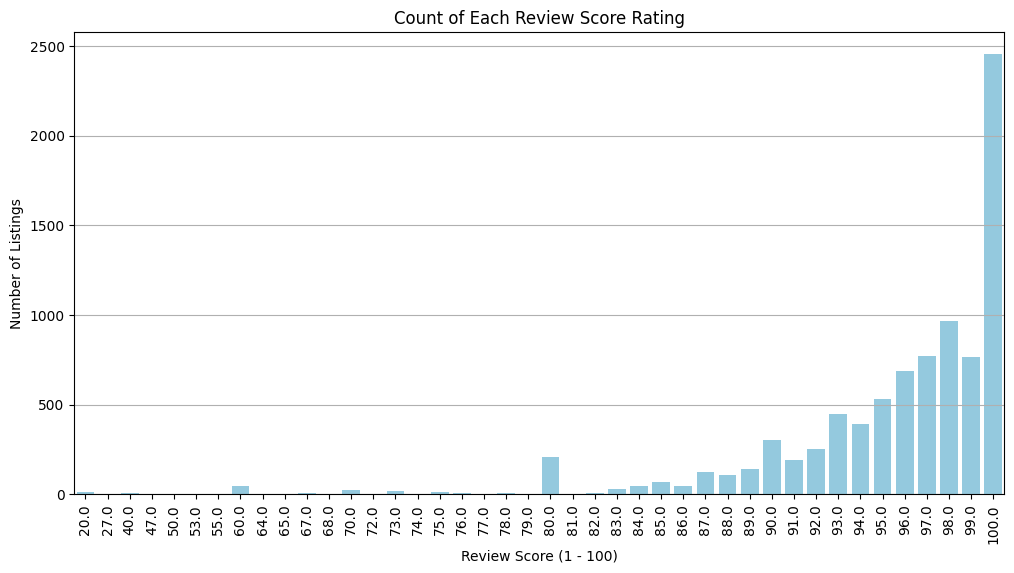

In [41]:
rating_counts = df['review_scores_rating'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, color='skyblue')
plt.title('Count of Each Review Score Rating')
plt.xlabel('Review Score (1 - 100)')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()

In [42]:
def tokenize_amenities(amenities_str):
   
    if pd.isna(amenities_str) or not amenities_str.strip():
        return []

 
    clean_str = amenities_str.strip().strip('{}')
    if not clean_str: 
        return []

   
    try:
        reader = csv.reader(
            StringIO(clean_str),
            quotechar='"',
            delimiter=',',
            skipinitialspace=True
        )
        tokens = next(reader, []) 
        return [token.strip('"\'') for token in tokens if token.strip()]
    except Exception as e:
        print(f"Failed to parse: '{amenities_str}' - Error: {str(e)}")
        return []

In [43]:
df['amenities_tokenized'] = df['amenities'].apply(tokenize_amenities)
print(df['amenities_tokenized'])

0       [TV, Wifi, Air conditioning, Pool, Kitchen, Fr...
1       [TV, Cable TV, Wifi, Kitchen, Free parking on ...
2       [TV, Internet, Wifi, Air conditioning, Kitchen...
3       [TV, Wifi, Air conditioning, Kitchen, Paid par...
4       [TV, Wifi, Air conditioning, Kitchen, Paid par...
                              ...                        
8719    [TV, Wifi, Air conditioning, Kitchen, Free par...
8720    [TV, Cable TV, Internet, Wifi, Kitchen, Free p...
8721    [TV, Cable TV, Wifi, Kitchen, Free street park...
8722    [TV, Wifi, Air conditioning, Pool, Kitchen, Fr...
8723    [TV, Wifi, Kitchen, Free parking on premises, ...
Name: amenities_tokenized, Length: 8724, dtype: object


In [44]:
all_amenities = df['amenities_tokenized'].explode().dropna()

amenity_counts = all_amenities.value_counts().to_dict()

In [45]:
all_amenities = df['amenities_tokenized'].explode().dropna()
amenity_weights = all_amenities.value_counts().to_dict()

total_weight = sum(amenity_weights.values())

In [46]:
df = shuffle(df)

In [50]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [51]:
unique_amenities = list(set(all_amenities))

results = []

for amenity in unique_amenities:
    has_amenity = df_train['amenities_tokenized'].apply(lambda x: amenity in x)

    if has_amenity.sum() == 0:
        continue

    mean_with = df_train[has_amenity]['review_scores_rating'].mean()
    mean_without = df_train[~has_amenity]['review_scores_rating'].mean()
    diff = mean_with - mean_without

    results.append({
        'amenity': amenity,
        'mean_with': mean_with,
        'mean_without': mean_without,
        'mean_diff': diff,
        'count': has_amenity.sum() 
    })

amenity_effects = pd.DataFrame(results)

scaler = MinMaxScaler()
amenity_effects['normalized_weight'] = scaler.fit_transform(amenity_effects[['mean_diff']])

amenity_effects = amenity_effects.sort_values('mean_diff', ascending=False)

In [52]:
amenity_effects.shape

(184, 6)

In [53]:
amenity_effects.head()

,amenity,mean_with,mean_without,mean_diff,count,normalized_weight
183,Standing valet,100.0,95.334528,4.665472,2,1.000000
8,Jetted tub,100.0,95.335196,4.664804,1,0.999931
55,Outdoor kitchen,100.0,95.335196,4.664804,1,0.999931
40,Shared gym,100.0,95.335196,4.664804,1,0.999931
43,Heated floors,100.0,95.335196,4.664804,1,0.999931


In [54]:
amenity_weights = dict(zip(amenity_effects['amenity'], amenity_effects['normalized_weight']))

In [55]:
def compute_amenity_score(amenities_list):
    return sum(amenity_weights.get(amenity, 0) for amenity in amenities_list)

df_train['amenity_score'] = df_train['amenities_tokenized'].apply(compute_amenity_score)
df_test['amenity_score'] = df_test['amenities_tokenized'].apply(compute_amenity_score)
df = pd.concat([df_train, df_test], axis=0).sort_index()

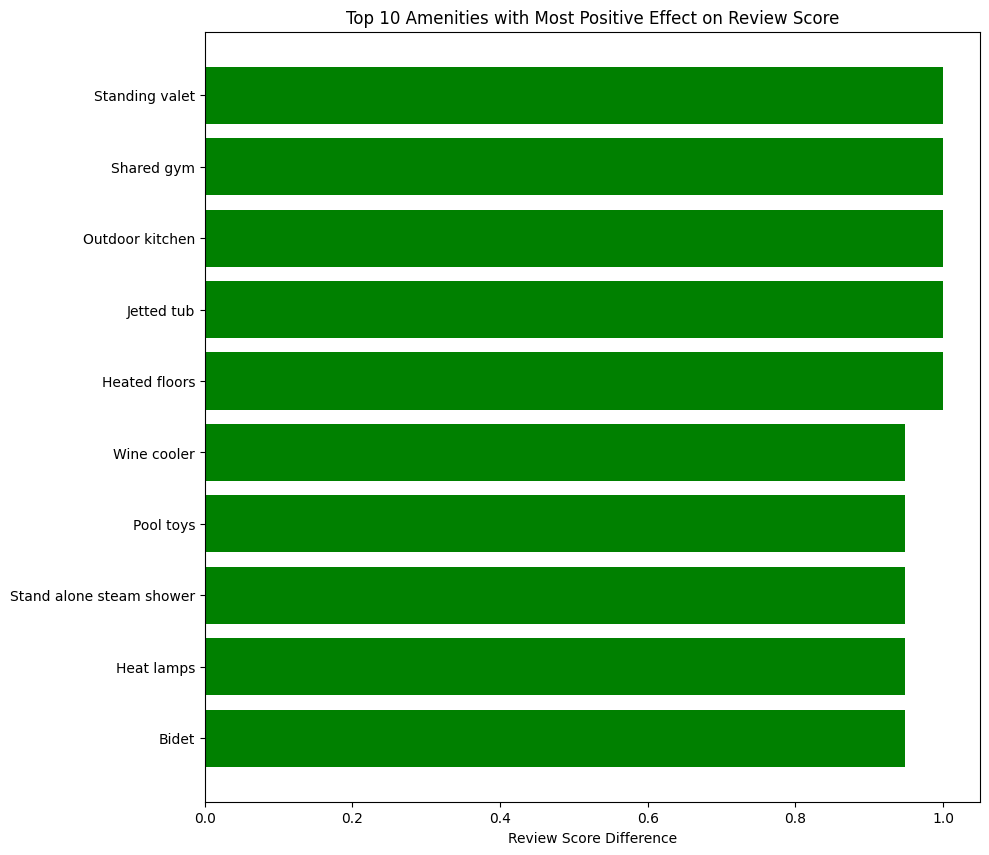

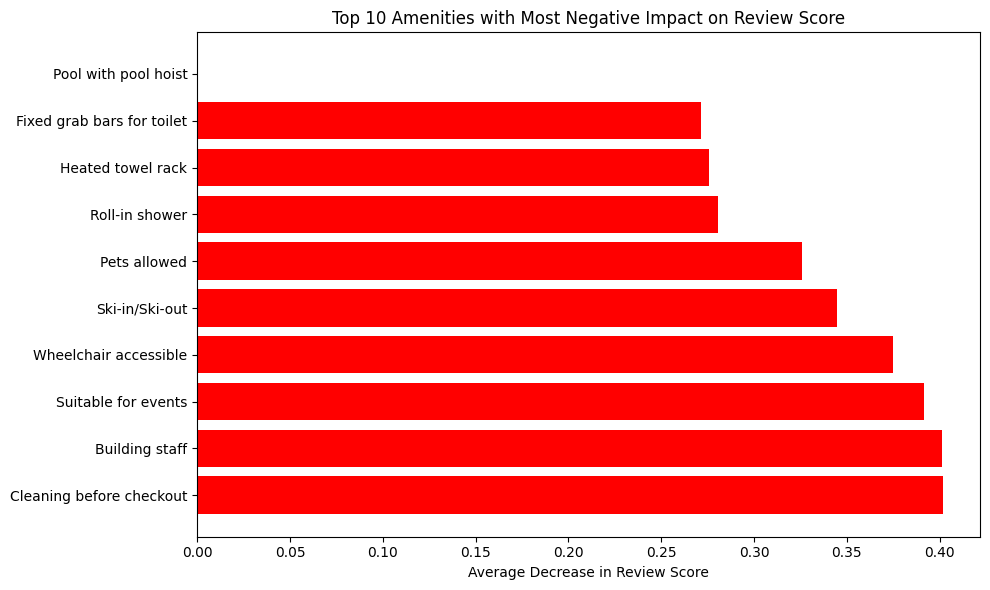

In [56]:

top_amenities = amenity_effects.sort_values('normalized_weight', ascending=False).head(10)
plt.figure(figsize=(10, 10))
plt.barh(top_amenities['amenity'], top_amenities['normalized_weight'], color='green')
plt.title("Top 10 Amenities with Most Positive Effect on Review Score")
plt.xlabel("Review Score Difference")
plt.gca().invert_yaxis()
plt.show()


bottom_10 = amenity_effects.sort_values('normalized_weight').head(10)

plt.figure(figsize=(10, 6))
plt.barh(bottom_10['amenity'], bottom_10['normalized_weight'], color='red')
plt.title("Top 10 Amenities with Most Negative Impact on Review Score")
plt.xlabel("Average Decrease in Review Score")
plt.gca().invert_yaxis()  # Most negative at top
plt.tight_layout()
plt.show()

In [57]:
df.head()

,host_name,host_location,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,street,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,number_of_stays,review_scores_rating,instant_bookable,cancellation_policy,host_since_year,host_since_month,host_since_dayofweek,first_review_year,first_review_month,first_review_dayofweek,last_review_year,last_review_month,last_review_dayofweek,notes_embedding,transit_embedding,access_embedding,interaction_embedding,house_rules_embedding,space_embedding,neighborhood_overview_embedding,description_embedding,summary_embedding,name_embedding,host_about_embedding,amenities_tokenized,amenity_score
0,116,235,2.0,90.0,0.0,Pacific Beach,19.0,19.0,1.0,"San Diego, CA, United States",24,92101,32.71104,-117.14980,1,1,1,1,1.0,1.0,2.0,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",40.0,200.0,0.0,50.0,1,0.0,5,365,1,2,80.0,0,3,2012.0,10.0,0.0,2017,11,4,2017,11,4,-0.002727,-0.000328,-0.000428,-0.000999,-0.000713,-0.000602,-0.000682,-0.000461,-0.000662,0.000293,-0.001208,"[TV, Wifi, Air conditioning, Pool, Kitchen, Fr...",12.472063
1,2174,235,2.0,100.0,0.0,Mira Mesa,1.0,1.0,0.0,"San Diego, CA, United States",52,92126,32.91785,-117.14942,1,23,0,8,2.0,4.0,5.0,4,"{TV,""Cable TV"",Wifi,Kitchen,""Free parking on p...",151.0,604.0,100.0,100.0,5,15.0,4,15,13,26,97.0,0,1,2013.0,1.0,1.0,2013,8,4,2019,7,2,-0.000787,0.000009,0.000022,-0.000879,-0.000373,-0.000514,-0.000970,-0.000453,-0.000744,0.000256,-0.000712,"[TV, Cable TV, Wifi, Kitchen, Free parking on ...",20.508140
2,1882,235,2.0,100.0,1.0,Hillcrest,12.0,12.0,0.0,"San Diego, CA, United States",50,92103,32.74337,-117.16539,1,1,0,3,1.0,1.0,1.0,4,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",119.0,119.0,200.0,90.0,1,14.0,1,365,85,170,98.0,0,3,2013.0,11.0,1.0,2017,7,6,2019,7,1,0.001361,-0.000992,0.000023,-0.001113,-0.000268,-0.000777,-0.000496,-0.001014,0.000217,0.000644,-0.000435,"[TV, Internet, Wifi, Air conditioning, Kitchen...",22.594094
3,2315,280,3.0,99.0,1.0,Little Italy,7.0,7.0,0.0,"San Diego, CA, United States",45,92101,32.72359,-117.16736,1,1,0,2,1.0,0.0,1.0,4,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",119.0,238.0,0.0,75.0,1,0.0,2,365,106,212,98.0,1,1,2018.0,4.0,2.0,2018,5,1,2019,8,5,-0.000266,-0.000406,-0.000918,-0.001178,-0.000095,-0.000482,0.000064,0.000499,0.000499,0.000276,0.001638,"[TV, Wifi, Air conditioning, Kitchen, Paid par...",25.947308
4,2254,235,3.0,100.0,1.0,La Jolla,63.0,63.0,1.0,"San Diego, CA, United States",53,92109,32.78778,-117.25280,0,1,0,6,1.0,2.0,4.0,4,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",550.0,550.0,800.0,165.0,4,20.0,2,365,1,2,100.0,1,3,2013.0,8.0,4.0,2019,6,6,2019,6,6,-0.000907,-0.000689,-0.000907,0.000352,-0.001141,-0.001430,-0.001395,-0.000940,-0.001334,-0.000376,-0.000063,"[TV, Wifi, Air conditioning, Kitchen, Paid par...",28.925072


In [58]:
df['total_cost'] = (
    df['nightly_price'] * df['minimum_nights'] #the same as price_per_stay
    + df['cleaning_fee'].fillna(0)
    + df['security_deposit'].fillna(0)
    + df['extra_people'].fillna(0) * df['guests_included'].fillna(0) * df['minimum_nights']
)

In [59]:
average_number_of_stays = df['number_of_stays'].mean()
df['is_frequently_booked'] = df['number_of_stays'] > average_number_of_stays

In [60]:
df[['bedrooms', 'bathrooms']] = df[['bedrooms', 'bathrooms']].fillna(1)
df['beds'] = df['beds'].fillna(df['bedrooms'])

In [61]:
df['space_to_people_ratio'] = (df['bedrooms'] + df['bathrooms']) / df['accommodates']

In [62]:
df.head()

,host_name,host_location,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,street,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,number_of_stays,review_scores_rating,instant_bookable,cancellation_policy,host_since_year,host_since_month,host_since_dayofweek,first_review_year,first_review_month,first_review_dayofweek,last_review_year,last_review_month,last_review_dayofweek,notes_embedding,transit_embedding,access_embedding,interaction_embedding,house_rules_embedding,space_embedding,neighborhood_overview_embedding,description_embedding,summary_embedding,name_embedding,host_about_embedding,amenities_tokenized,amenity_score,total_cost,is_frequently_booked,space_to_people_ratio
0,116,235,2.0,90.0,0.0,Pacific Beach,19.0,19.0,1.0,"San Diego, CA, United States",24,92101,32.71104,-117.14980,1,1,1,1,1.0,1.0,2.0,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",40.0,200.0,0.0,50.0,1,0.0,5,365,1,2,80.0,0,3,2012.0,10.0,0.0,2017,11,4,2017,11,4,-0.002727,-0.000328,-0.000428,-0.000999,-0.000713,-0.000602,-0.000682,-0.000461,-0.000662,0.000293,-0.001208,"[TV, Wifi, Air conditioning, Pool, Kitchen, Fr...",12.472063,250.0,False,2.000000
1,2174,235,2.0,100.0,0.0,Mira Mesa,1.0,1.0,0.0,"San Diego, CA, United States",52,92126,32.91785,-117.14942,1,23,0,8,2.0,4.0,5.0,4,"{TV,""Cable TV"",Wifi,Kitchen,""Free parking on p...",151.0,604.0,100.0,100.0,5,15.0,4,15,13,26,97.0,0,1,2013.0,1.0,1.0,2013,8,4,2019,7,2,-0.000787,0.000009,0.000022,-0.000879,-0.000373,-0.000514,-0.000970,-0.000453,-0.000744,0.000256,-0.000712,"[TV, Cable TV, Wifi, Kitchen, Free parking on ...",20.508140,1104.0,False,0.750000
2,1882,235,2.0,100.0,1.0,Hillcrest,12.0,12.0,0.0,"San Diego, CA, United States",50,92103,32.74337,-117.16539,1,1,0,3,1.0,1.0,1.0,4,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",119.0,119.0,200.0,90.0,1,14.0,1,365,85,170,98.0,0,3,2013.0,11.0,1.0,2017,7,6,2019,7,1,0.001361,-0.000992,0.000023,-0.001113,-0.000268,-0.000777,-0.000496,-0.001014,0.000217,0.000644,-0.000435,"[TV, Internet, Wifi, Air conditioning, Kitchen...",22.594094,423.0,True,0.666667
3,2315,280,3.0,99.0,1.0,Little Italy,7.0,7.0,0.0,"San Diego, CA, United States",45,92101,32.72359,-117.16736,1,1,0,2,1.0,0.0,1.0,4,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",119.0,238.0,0.0,75.0,1,0.0,2,365,106,212,98.0,1,1,2018.0,4.0,2.0,2018,5,1,2019,8,5,-0.000266,-0.000406,-0.000918,-0.001178,-0.000095,-0.000482,0.000064,0.000499,0.000499,0.000276,0.001638,"[TV, Wifi, Air conditioning, Kitchen, Paid par...",25.947308,313.0,True,0.500000
4,2254,235,3.0,100.0,1.0,La Jolla,63.0,63.0,1.0,"San Diego, CA, United States",53,92109,32.78778,-117.25280,0,1,0,6,1.0,2.0,4.0,4,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",550.0,550.0,800.0,165.0,4,20.0,2,365,1,2,100.0,1,3,2013.0,8.0,4.0,2019,6,6,2019,6,6,-0.000907,-0.000689,-0.000907,0.000352,-0.001141,-0.001430,-0.001395,-0.000940,-0.001334,-0.000376,-0.000063,"[TV, Wifi, Air conditioning, Kitchen, Paid par...",28.925072,2225.0,False,0.500000


In [63]:
for col in text_columns:
    emb_col = f"{col}_embedding"
    correlation = df[[emb_col, 'review_scores_rating']].corr().iloc[0, 1]
    print(f"{col} embedding correlation with review_scores_rating: {correlation:.4f}")

notes embedding correlation with review_scores_rating: 0.0019
transit embedding correlation with review_scores_rating: 0.0044
access embedding correlation with review_scores_rating: 0.0341
interaction embedding correlation with review_scores_rating: 0.0035
house_rules embedding correlation with review_scores_rating: 0.0568
space embedding correlation with review_scores_rating: 0.0329
neighborhood_overview embedding correlation with review_scores_rating: -0.0008
description embedding correlation with review_scores_rating: 0.0484
summary embedding correlation with review_scores_rating: 0.0191
name embedding correlation with review_scores_rating: 0.0149
host_about embedding correlation with review_scores_rating: -0.0029


In [64]:
anova_results = []
for col in discrete_columns:
    try:
        groups = [group['review_scores_rating'].dropna().values
                  for _, group in df.groupby(col) if len(group) > 1]

        if len(groups) >= 2:
            f_val, p_val = f_oneway(*groups)
            anova_results.append({'feature': col, 'f_statistic': f_val, 'p_value': p_val})
    except Exception as e:
        print(f"Skipping {col} due to error: {e}")

anova_df = pd.DataFrame(anova_results).sort_values(by='f_statistic', ascending=False)

fig = px.bar(
    anova_df,
    x='f_statistic',
    y='feature',
    orientation='h',
    color='f_statistic',
    color_continuous_scale='Viridis',
    title='ANOVA F-statistics for Discrete Features vs Review Score'
)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

In [65]:
top_discrete_features = anova_df.nlargest(4, 'f_statistic')['feature'].tolist()
anova_df.head()

,feature,f_statistic,p_value
1,host_is_superhost,601.394022,1.741545e-128
11,instant_bookable,58.116375,2.729569e-14
12,cancellation_policy,49.508446,9.962711e-51
3,is_location_exact,44.882522,2.221731e-11
4,room_type,18.663531,8.162600e-09


In [66]:
df = df[[col for col in df.columns if col != 'review_scores_rating'] + ['review_scores_rating']]

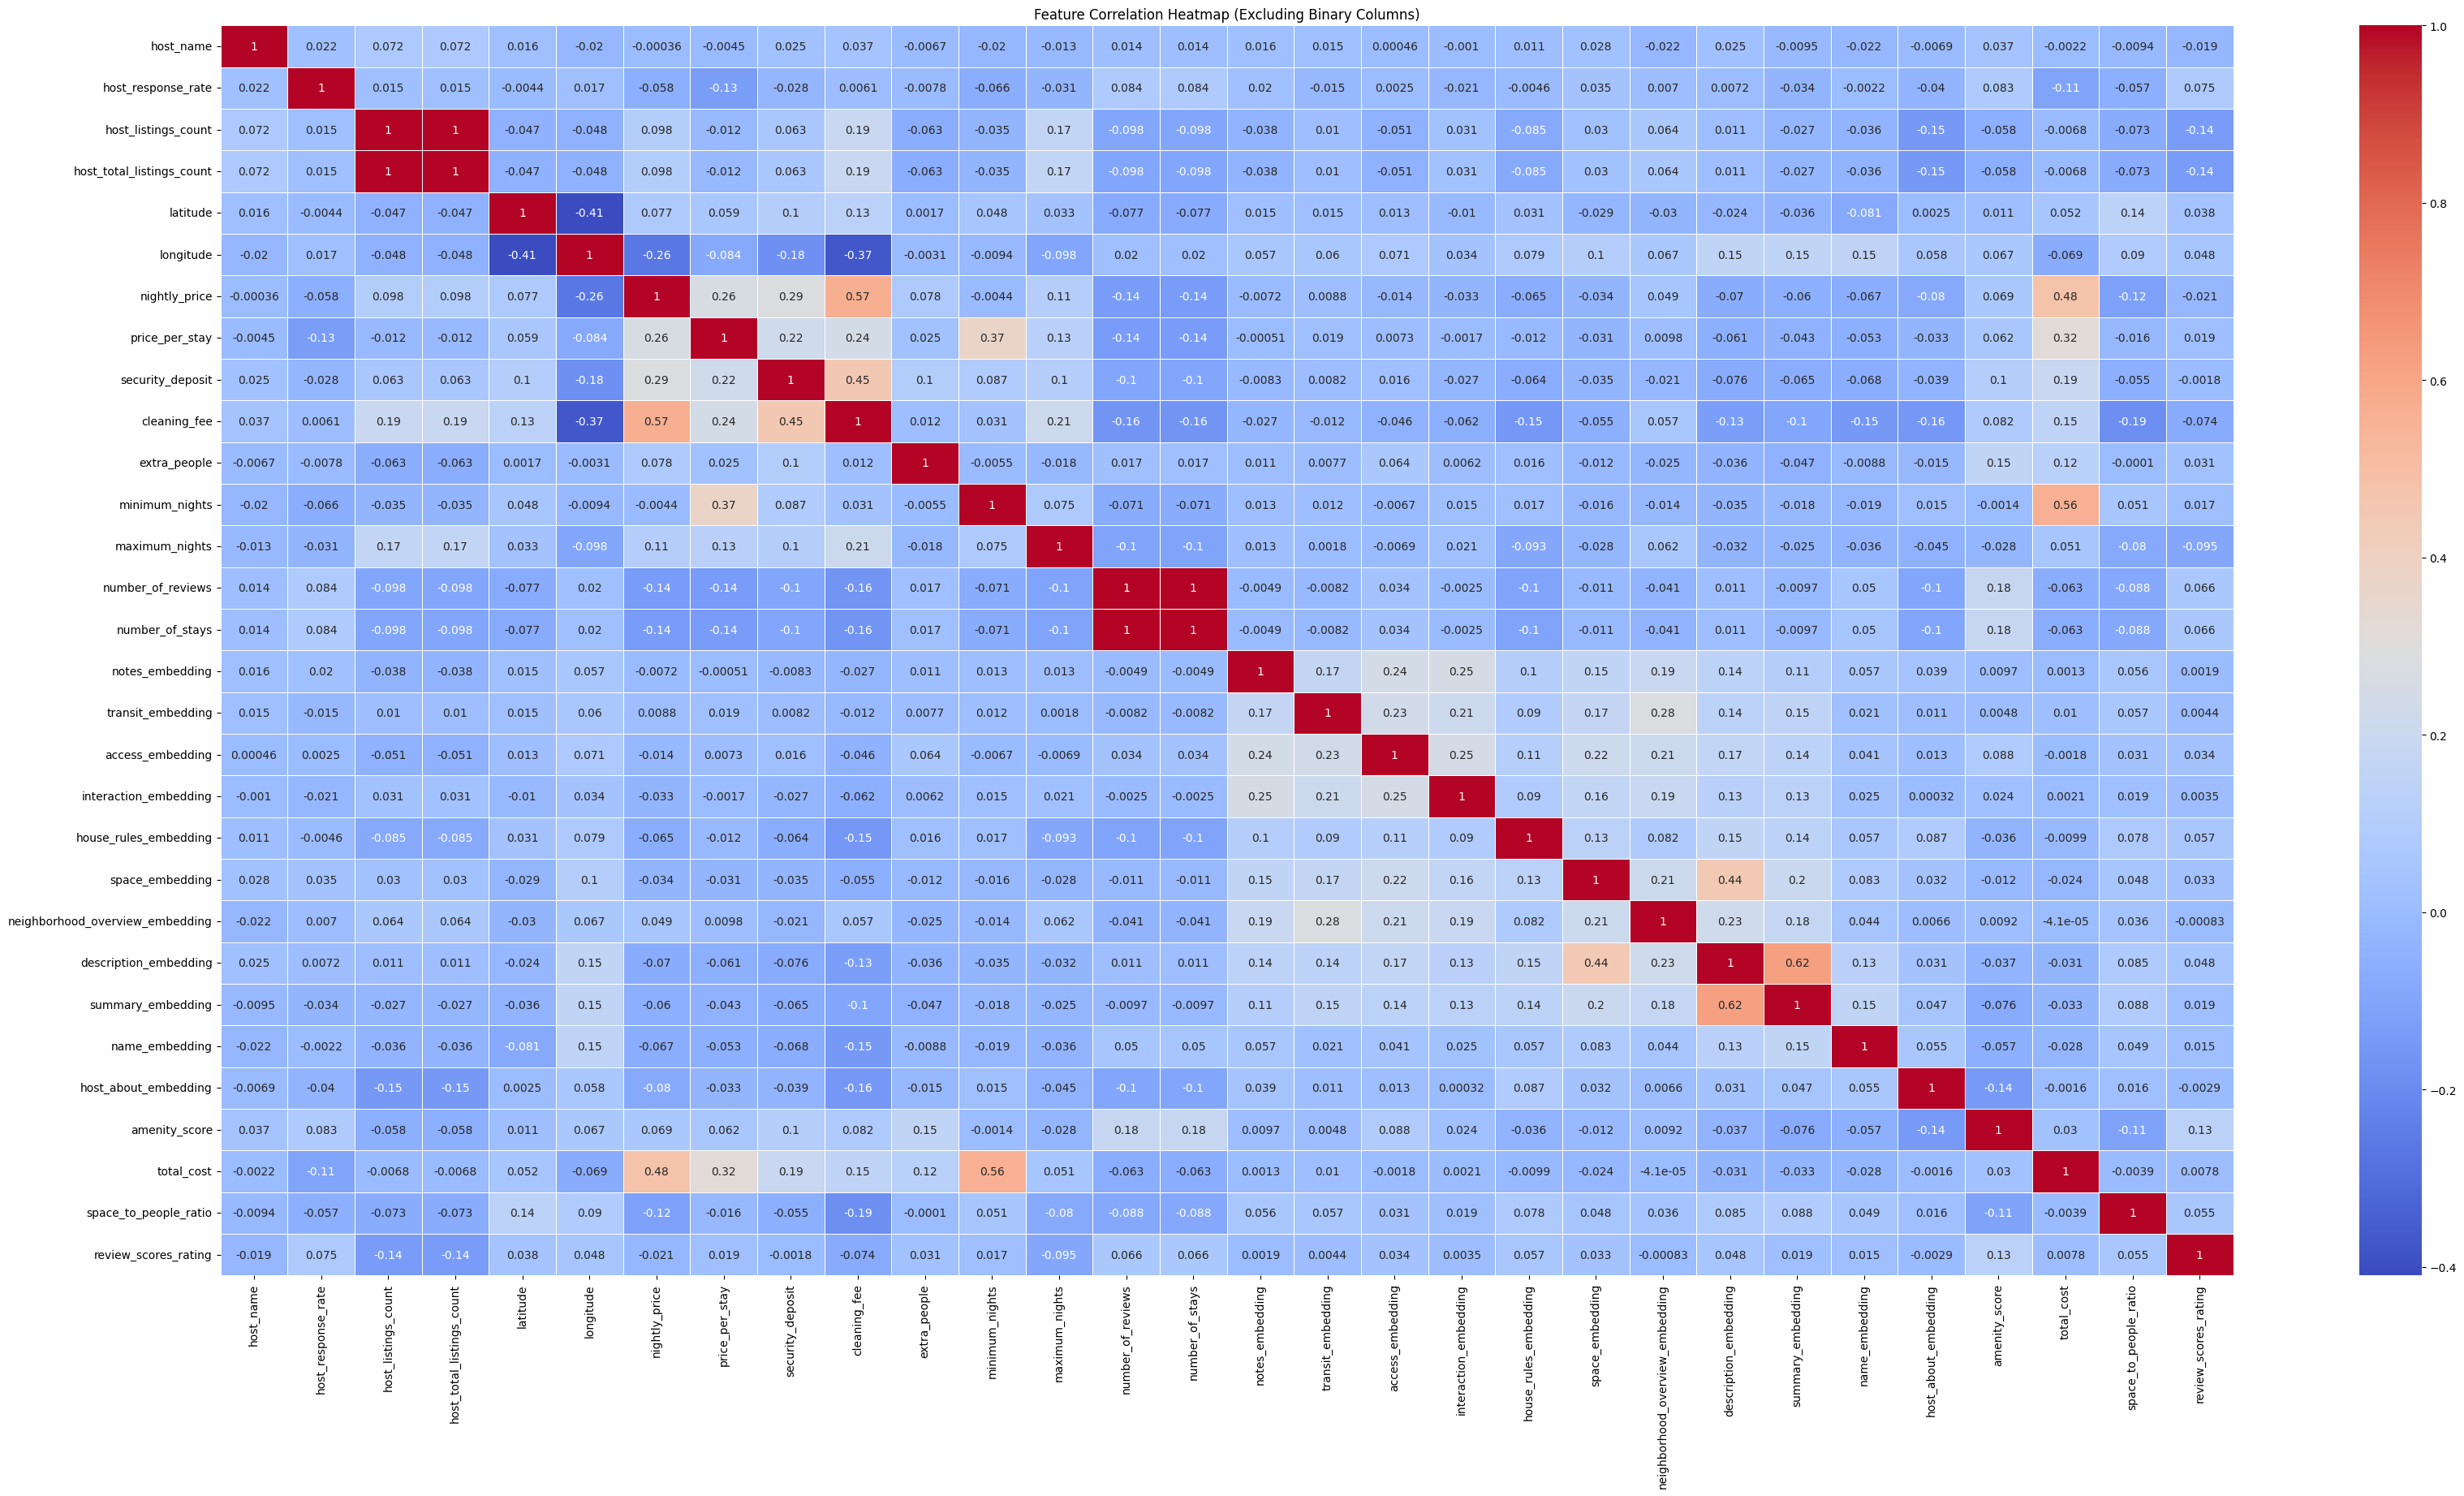

In [67]:
numeric_df = df.select_dtypes(include=['number'])

non_discrete_df = numeric_df.loc[:, ~numeric_df.columns.isin(discrete_columns)]

plt.figure(figsize=(40,20))
correlation_matrix = non_discrete_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Excluding Binary Columns)")
plt.show()

In [68]:
correlation_with_target = correlation_matrix['review_scores_rating'].abs().drop('review_scores_rating')

top_continuous_features = correlation_with_target.nlargest(4).index.tolist()

print (top_continuous_features)

['host_listings_count', 'host_total_listings_count', 'amenity_score', 'maximum_nights']


In [70]:
df['host_is_superhost'] = df['host_is_superhost'].fillna(1)

In [71]:
outliers_dict = {}

for col in top_continuous_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = len(outliers)

for col, count in outliers_dict.items():
    print(f"{col}: {count} outliers")

host_listings_count: 1301 outliers
host_total_listings_count: 1301 outliers
amenity_score: 59 outliers
maximum_nights: 0 outliers


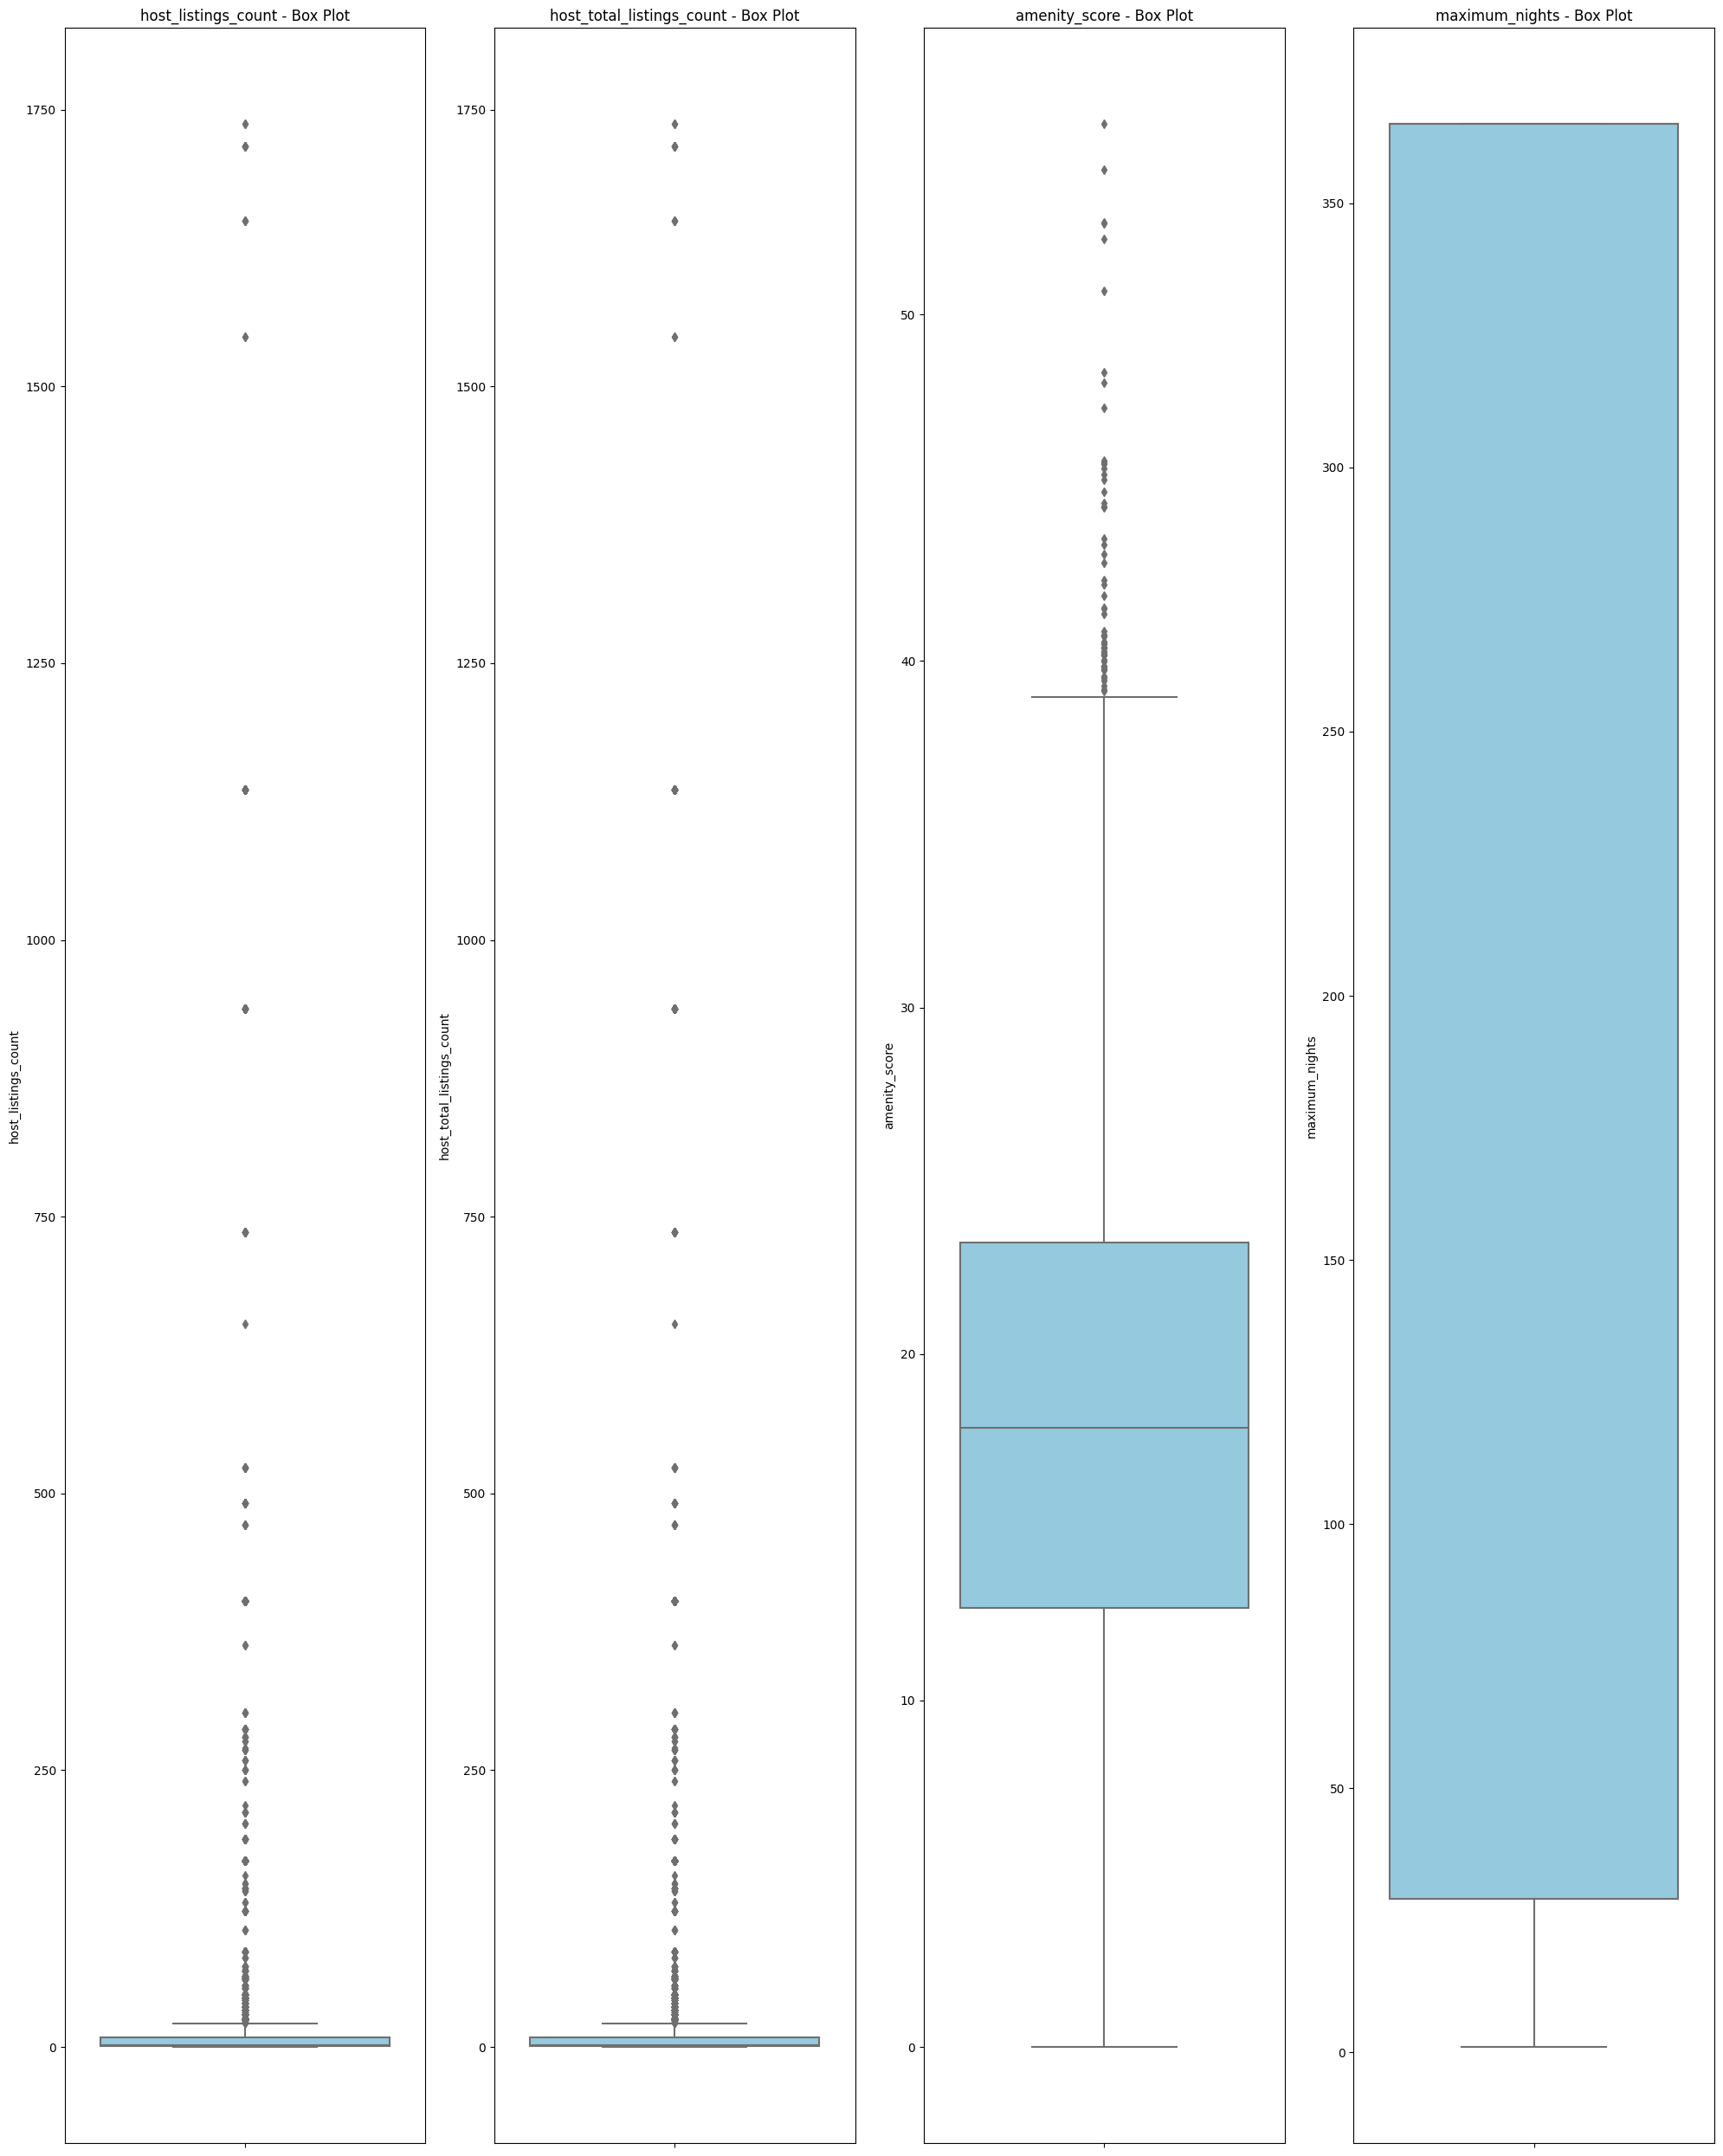

In [72]:
plt.figure(figsize=(20, 25))
cols = 4 

for i, col in enumerate(top_continuous_features):
    plt.subplot((len(top_continuous_features) + cols - 1) // cols, cols, i + 1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"{col} - Box Plot")
    plt.tight_layout()

plt.show()


In [74]:
chosen_features = top_discrete_features + top_continuous_features
model_df = df[[c for c in chosen_features if c in df.columns] + ['review_scores_rating']].copy()
model_df[top_discrete_features] = model_df[top_discrete_features].astype(int)

In [75]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8724 entries, 0 to 8723
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   host_name                        8724 non-null   int64  
 1   host_location                    8724 non-null   int64  
 2   host_response_time               8724 non-null   float64
 3   host_response_rate               8724 non-null   float64
 4   host_is_superhost                8724 non-null   float64
 5   host_neighbourhood               8724 non-null   object 
 6   host_listings_count              8724 non-null   float64
 7   host_total_listings_count        8724 non-null   float64
 8   host_identity_verified           8723 non-null   float64
 9   street                           8724 non-null   object 
 10  neighbourhood_cleansed           8724 non-null   int64  
 11  zipcode                          8724 non-null   object 
 12  latitude                 

In [76]:
X = model_df.drop(columns=['review_scores_rating'])
y = model_df['review_scores_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 5],
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_rf_grid = grid_search.best_estimator_

with open('best_random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf_grid, f)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   5.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estim

In [78]:


y_pred_random = best_rf_grid.predict(X_test)

mse_random = mean_squared_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)

print(f"Mean Squared Error: {mse_random:.2f}")
print(f"R-squawred: {r2_random:.2f}")

Mean Squared Error: 42.67
R-squawred: 0.11


In [79]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'regressor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_poly = grid_search.best_estimator_

with open('best_polynomial_model.pkl', 'wb') as f:
    pickle.dump(best_poly, f)

Best Hyperparameters: {'poly__degree': 2, 'regressor__fit_intercept': False}


In [80]:
# with open('best_polynomial_model.pkl', 'rb') as f:
#     best_poly = pickle.load(f)

y_pred = best_poly.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 43.43
R-squared: 0.09


In [81]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],         
    'max_depth': [4, 6, 8],                     
    'n_estimators': [100, 300, 500],             
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid_xgb,
                               cv=5,
                               verbose=2,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

grid_search_xgb.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search_xgb.best_params_}")

best_xgb = grid_search_xgb.best_estimator_

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.2s[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.2s

[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.1s[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.2s

[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_e

In [82]:
# with open('best_xgb_model.pkl', 'rb') as f:
#     best_xgb = pickle.load(f)

y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 42.05
R-squared: 0.12


In [83]:
param_grid_catboost = {
    'iterations': [500, 1000, 1500],          # fewer options
    'learning_rate': [0.01, 0.05, 0.1],        # typical good ranges
    'depth': [6, 8, 10],                      # reasonable depths
}

catboost_model = CatBoostRegressor(cat_features=top_discrete_features, silent=True, random_state=42)

grid_search_catboost = GridSearchCV(estimator=catboost_model,
                                    param_grid=param_grid_catboost,
                                    cv=5,
                                    verbose=2,
                                    n_jobs=-1,
                                    scoring='neg_mean_squared_error')

grid_search_catboost.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search_catboost.best_params_}")

best_catboost = grid_search_catboost.best_estimator_

with open('best_catboost_model.pkl', 'wb') as f:
    pickle.dump(best_catboost, f)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ........depth=6, iterations=500, learning_rate=0.01; total time=   3.9s
[CV] END ........depth=6, iterations=500, learning_rate=0.01; total time=   4.1s
[CV] END ........depth=6, iterations=500, learning_rate=0.01; total time=   4.6s
[CV] END ........depth=6, iterations=500, learning_rate=0.01; total time=   4.9s
[CV] END ........depth=6, iterations=500, learning_rate=0.01; total time=   3.8s
[CV] END ........depth=6, iterations=500, learning_rate=0.05; total time=   3.9s
[CV] END ........depth=6, iterations=500, learning_rate=0.05; total time=   3.9s
[CV] END ........depth=6, iterations=500, learning_rate=0.05; total time=   4.0s
[CV] END ........depth=6, iterations=500, learning_rate=0.05; total time=   4.3s
[CV] END ........depth=6, iterations=500, learning_rate=0.05; total time=   4.7s
[CV] END .........depth=6, iterations=500, learning_rate=0.1; total time=   3.9s
[CV] END .........depth=6, iterations=500, lear

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV] END .......depth=8, iterations=1500, learning_rate=0.05; total time=  22.5s
[CV] END .......depth=8, iterations=1500, learning_rate=0.05; total time=  24.2s
[CV] END .......depth=8, iterations=1500, learning_rate=0.05; total time=  20.2s
[CV] END ........depth=8, iterations=1500, learning_rate=0.1; total time=  22.4s
[CV] END ........depth=8, iterations=1500, learning_rate=0.1; total time=  25.4s
[CV] END ........depth=8, iterations=1500, learning_rate=0.1; total time=  24.4s
[CV] END ........depth=8, iterations=1500, learning_rate=0.1; total time=  24.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV] END .......depth=10, iterations=500, learning_rate=0.01; total time=  11.7s
[CV] END ........depth=8, iterations=1500, learning_rate=0.1; total time=  22.4s
[CV] END .......depth=10, iterations=500, learning_rate=0.01; total time=  11.6s
[CV] END .......depth=10, iterations=500, learning_rate=0.01; total time=  12.7s
[CV] END .......depth=10, iterations=500, learning_rate=0.01; total time=  12.9s
[CV] END .......depth=10, iterations=500, learning_rate=0.01; total time=  12.2s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV] END .......depth=10, iterations=500, learning_rate=0.05; total time=  12.9s
[CV] END .......depth=10, iterations=500, learning_rate=0.05; total time=  13.4s
[CV] END .......depth=10, iterations=500, learning_rate=0.05; total time=  12.9s
[CV] END .......depth=10, iterations=500, learning_rate=0.05; total time=  13.3s
[CV] END .......depth=10, iterations=500, learning_rate=0.05; total time=  12.9s
[CV] END ........depth=10, iterations=500, learning_rate=0.1; total time=  13.3s
[CV] END ........depth=10, iterations=500, learning_rate=0.1; total time=  13.7s
[CV] END ........depth=10, iterations=500, learning_rate=0.1; total time=  12.9s
[CV] END ........depth=10, iterations=500, learning_rate=0.1; total time=  14.0s
[CV] END ........depth=10, iterations=500, learning_rate=0.1; total time=  13.1s
[CV] END ......depth=10, iterations=1000, learning_rate=0.01; total time=  21.3s
[CV] END ......depth=10, iterations=1000, learning_rate=0.01; total time=  24.0s
[CV] END ......depth=10, ite

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV] END ......depth=10, iterations=1000, learning_rate=0.01; total time=  24.7s
[CV] END ......depth=10, iterations=1000, learning_rate=0.01; total time=  23.5s
[CV] END ......depth=10, iterations=1000, learning_rate=0.05; total time=  28.5s
[CV] END ......depth=10, iterations=1000, learning_rate=0.05; total time=  29.4s
[CV] END ......depth=10, iterations=1000, learning_rate=0.05; total time=  29.2s
[CV] END ......depth=10, iterations=1000, learning_rate=0.05; total time=  29.8s
[CV] END ......depth=10, iterations=1000, learning_rate=0.05; total time=  29.6s
[CV] END .......depth=10, iterations=1000, learning_rate=0.1; total time=  30.5s
[CV] END .......depth=10, iterations=1000, learning_rate=0.1; total time=  32.9s
[CV] END .......depth=10, iterations=1000, learning_rate=0.1; total time=  31.2s
[CV] END .......depth=10, iterations=1000, learning_rate=0.1; total time=  31.6s
[CV] END .......depth=10, iterations=1000, learning_rate=0.1; total time=  29.8s
[CV] END ......depth=10, ite

In [84]:
# with open('best_catboost_model.pkl', 'rb') as f:
#     best_catboost = pickle.load(f)

y_pred = best_catboost.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 42.19
R-squared: 0.12


In [85]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('regressor', SVR())
])

param_grid = {
    'poly__degree': [1, 2],                    # fewer polynomial degrees
    'regressor__kernel': ['rbf', 'poly'],       # focus on commonly good kernels
    'regressor__C': [0.1, 1, 10],               # fewer C values
    'regressor__epsilon': [0.1, 0.2],           # narrower range
    'regressor__degree': [2, 3],                # if 'poly' kernel is used
    'regressor__gamma': ['scale'],              # only 'scale'
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_svr = grid_search.best_estimator_

with open('best_svr_model.pkl', 'wb') as f:
    pickle.dump(best_svr, f)

print("Best SVR model saved to 'best_svr_model.pkl'")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END poly__degree=1, regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=rbf; total time=   2.1s
[CV] END poly__degree=1, regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=rbf; total time=   2.1s
[CV] END poly__degree=1, regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=rbf; total time=   2.1s
[CV] END poly__degree=1, regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=rbf; total time=   2.1s
[CV] END poly__degree=1, regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   1.7s
[CV] END poly__degree=1, regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   1.7s
[CV] END poly__degree=1, regressor__C=0.1, regressor__degree=2, regressor_

In [86]:


y_pred = best_svr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 46.24
R-squared: 0.03
